In [1]:
import os
from pathlib import Path
import options_wizard as ow
import polars as pl
from dotenv import load_dotenv
load_dotenv()


True

In [2]:
from pathlib import Path
import os

path = Path(os.getenv("CMDTY_PATH", "."))

names = [
    p.stem.removesuffix("_FUT")   
    for p in path.glob("*_FUT.parquet")
]


In [3]:
carry_spec: ow.CarryTradeSpec = ow.CarryTradeSpec(
    tenor_targets = [1, 3, 6],
    exposure_targets=[-1,  0.15, 0.85],
    roll_target=5,
    metric = "FRONT_RELATIVE",
    spread_override_bps = 10.0,
    
)

suffix = 'cmdty_carry_v1'

In [4]:
universe = ow.Universe(names)
save_type = ow.SaveType.PICKLE
pipeline = ow.Pipeline(universe=universe, save_type=save_type, saves = [ow.SaveFrames.STRAT])
kwargs = {
    "carry_spec": carry_spec,
    "suffix": suffix,
    "vol_window": 60
}

ow.add_cmdty_carry_methods(pipeline, kwargs)

In [ ]:
pipeline.run()

  0%|          | 0/28 [00:00<?, ?it/s]

 89%|████████▉ | 25/28 [07:54<00:37, 12.46s/it, failed=4]

In [ ]:
import options_wizard as ow
from functools import partial
  
start_cash = 1_000_000
start_date = ow.DateObj(2008, 1, 1)
end_date = ow.DateObj(2020, 12, 31)

ptf = partial(
    ow.Trade,
    transaction_cost_model=ow.TransactionCostModel.SPREAD,
    accounting_type=ow.AccountingConvention.MTM
)
cfg = ow.BackTestConfig(
    starting_cash = start_cash,
    start_date=start_date,
    end_date=end_date,
    kwargs=kwargs,
)

position = ow.FuturesCarry(cfg)

for tick in universe.ticks:
    try:
        strat = ow.StratType.load(tick, save_type=save_type, suffix=suffix)  
        trades = strat.reconstruct(ptf)
        for trade in trades:
            spread_capture_override = 1.0
            trade._spread_capture = spread_capture_override
        position.add_trade(trades)
    except FileNotFoundError:
        print(f"Data for {tick} not found, skipping.")

Data for IOE not found, skipping.
Data for O not found, skipping.
Data for SM not found, skipping.
Data for S not found, skipping.
Data for W not found, skipping.


In [ ]:
# build exchange list from data
exch_codes = set()
for tick in universe.ticks:
    df_exch = pl.read_parquet(path / f"{tick}_FUT.parquet", columns=["EXCH_CODE"])
    exch_codes.update(df_exch["EXCH_CODE"].unique().to_list())

dates = ow.market_dates_union(
    start_date,
    end_date,
    exchanges=sorted(exch_codes),
)

result = ow.BackTestCoordinator(
    position=position,
    dates=dates,
    debug=True,
).run()

100%|██████████| 3381/3381 [00:21<00:00, 154.57it/s]


Text(0, 0.5, 'Number of Open Trades')

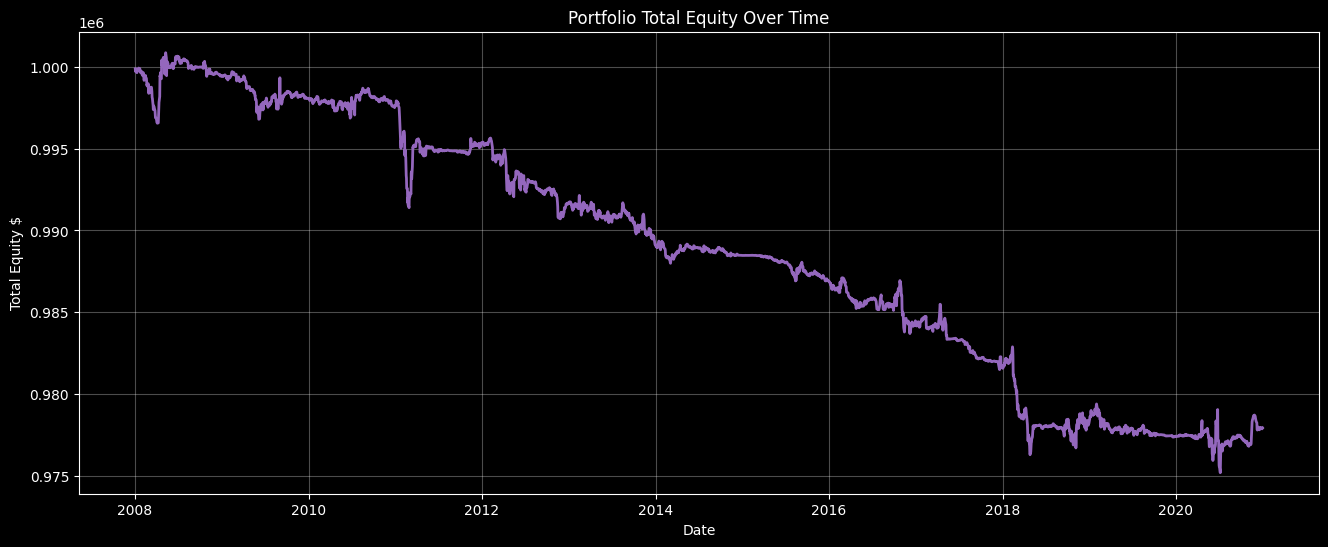

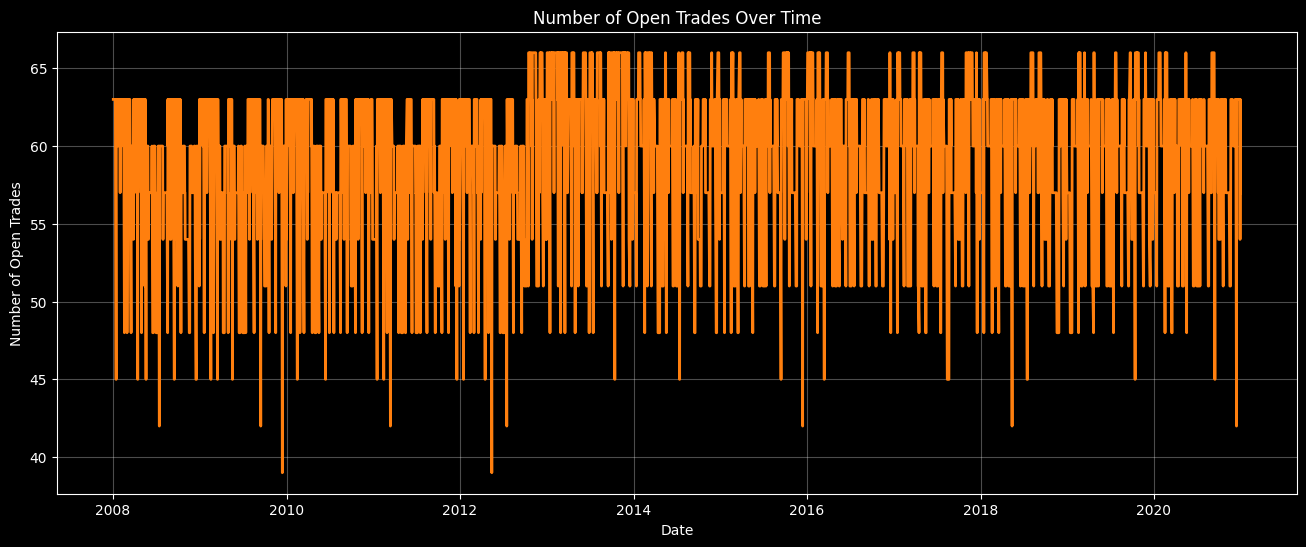

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotx 
import numpy as np
from statistics import mean

mpl.style.use("dark_background")

equity = np.array([snap.total_equity + snap.total_cash for snap in result.snapshots])
n_trades = np.array([len([key for key in snap.trade_equities.keys()]) for snap in result.snapshots])

dates = np.array([snap.date.to_datetime() for snap in result.snapshots])

fig2, ax2 = plt.subplots(figsize=(16, 6))
ax2.plot(dates, equity, color="tab:purple", lw=2, label="Total Equity")
ax2.grid(True, alpha=0.3)
ax2.set_title("Portfolio Total Equity Over Time")
ax2.set_xlabel("Date")
ax2.set_ylabel("Total Equity $")

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(dates, n_trades, color="tab:orange", lw=2, label="Number of Open Trades")
ax.grid(True, alpha=0.3)
ax.set_title("Number of Open Trades Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Open Trades")  